## Define Model

In [1]:
import matplotlib
from keras import backend as K
K.set_image_dim_ordering('th')

/home/callum/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
Using cuDNN version 7005 on context None
Preallocating 4861/6077 Mb (0.800000) on cuda0
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(layers, filters):
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu'))  # Keras2
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
def FCBlock():
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.6))
        #model.add(BatchNormalization())

In [21]:
model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))
ConvBlock(2, 64)
ConvBlock(2, 128)
ConvBlock(3, 256)
ConvBlock(3, 512)
ConvBlock(3, 512)

model.add(Flatten())
FCBlock()
FCBlock()
model.add(Dense(1000, activation='softmax'))
model.load_weights('fastai/models/vgg16.h5')
for layer in model.layers: layer.trainable=False
model.pop()
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights('models/statefarm.h5')

In [27]:
Dropout_indxs = [index for index,layer in enumerate(model.layers) 
                     if type(layer) is Dropout][::-1]
fake_model = Sequential(model.layers[:35])
#fake_model.add(BatchNormalization())
fake_model.add(model.layers[35])
fake_model.add(model.layers[36])
#fake_model.add(BatchNormalization())
fake_model.add(model.layers[-1])
for layer in fake_model.layers[33:]:
    layer.trainable=True
#model.optimizer.lr.set_value(0.0001)
fake_model.compile(optimizer=RMSprop(lr=.00001, rho=.7), loss='categorical_crossentropy', metrics=['accuracy'])
#model.load_weights('models/dogscats_ft_preprocessed2.h5')

In [5]:
conv_layers = model.layers[:31]
conv_model = Sequential(conv_layers)
fc_layers = model.layers[31:]

### Import the data

In [6]:
path='data/statefarm'
train_path=path+"/train"
valid_path=path+"/valid"

In [29]:
#Get data
from keras.preprocessing import image

#gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=.1, height_shift_range=.1,
#                              shear_range=.15, zoom_range=.1, channel_shift_range=10.,
#                              horizontal_flip=True)
gen = image.ImageDataGenerator()
batch_size=24

train_batches = gen.flow_from_directory(train_path, target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)
val_batches = gen.flow_from_directory(valid_path, target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=batch_size)

classes = list(iter(train_batches.class_indices)) # get a list of all the class labels

for c in train_batches.class_indices:
    classes[train_batches.class_indices[c]] = c

Found 18424 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [8]:
steps_per_epoch = int(np.ceil(train_batches.samples/batch_size))
validation_steps = int(np.ceil(val_batches.samples/batch_size))

# trn_classes = train_batches.classes
# val_classes = val_batches.classes
# val_features = conv_model.predict_generator(val_batches, validation_steps)
# trn_features = conv_model.predict_generator(train_batches, steps_per_epoch)
# trn_features.shape

## Fit the model

In [24]:
#for layer in fake_model.layers[33:]:
#    layer.trainable=True
model.optimizer.lr = 0.00001
#model.summary()

In [26]:
#Fit Model
#model.load_weights('models/dogscats2.h5')

model.fit_generator(train_batches, steps_per_epoch=int(np.ceil(train_batches.samples/batch_size)), epochs=3,
                validation_data=val_batches, validation_steps=int(np.ceil(val_batches.samples/batch_size)))
model.save_weights('models/statefarm.h5')

Epoch 1/3
768/767 [==============================] - 226s 295ms/step - loss: 1.7374 - acc: 0.4761 - val_loss: 0.8925 - val_acc: 0.7088
Epoch 2/3
768/767 [==============================] - 226s 294ms/step - loss: 1.6843 - acc: 0.4849 - val_loss: 0.8624 - val_acc: 0.7268
Epoch 3/3
768/767 [==============================] - 227s 295ms/step - loss: 1.6369 - acc: 0.4891 - val_loss: 0.8598 - val_acc: 0.7313


In [30]:
#Fit Model

fake_model.fit_generator(train_batches, steps_per_epoch=int(np.ceil(train_batches.samples/batch_size)), epochs=1,
                validation_data=val_batches, validation_steps=int(np.ceil(val_batches.samples/batch_size)))
mode

Epoch 1/1
768/767 [==============================] - 248s 323ms/step - loss: 0.3171 - acc: 0.9045 - val_loss: 0.0533 - val_acc: 0.9850


In [31]:
fake_model.save_weights('models/statefarm2.h5')

## Examine Results

In [38]:
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import matplotlib.pyplot as plt
#Use the plots helper function
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



In [39]:
sample_batches = gen.flow_from_directory(train_path, target_size=(224,224), class_mode='categorical', shuffle=True, batch_size=4)

Found 18424 images belonging to 10 classes.


In [42]:
# Get a few images and their true labels
imgs, labels = sample_batches.next()
indxs = np.argmax(labels, axis=1)
indxs
labels = [classes[indx] for indx in indxs]
true_labels_dict = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}
true_labels = [true_labels_dict[label] for label in labels]

In [43]:
plots(imgs, titles=true_labels)

## Test Model

In [46]:
#fake_model.load_weights('models/dogscats_ft_preprocessed2.h5')
test_batches = gen.flow_from_directory(path+'/test', target_size=(224,224), class_mode='categorical', shuffle=False, batch_size=20)
test_steps = int(np.ceil(test_batches.samples/batch_size))
ids = []
for filename in test_batches.filenames:
    ids.append(filename.split('/')[1])
#preds = fake_model.predict_generator(test_batches, test_steps)
#ids = []


Found 79726 images belonging to 1 classes.


In [59]:
import pandas as pd
df = pd.DataFrame()
df['img'] = ids
df['c0'] = np.clip(preds[:, 0], 0.05, 0.95)
df['c1'] = np.clip(preds[:, 1], 0.05, 0.95)
df['c2'] = np.clip(preds[:, 2], 0.05, 0.95)
df['c3'] = np.clip(preds[:, 3], 0.05, 0.95)
df['c4'] = np.clip(preds[:, 4], 0.05, 0.95)
df['c5'] = np.clip(preds[:, 5], 0.05, 0.95)
df['c6'] = np.clip(preds[:, 6], 0.05, 0.95)
df['c7'] = np.clip(preds[:, 7], 0.05, 0.95)
df['c8'] = np.clip(preds[:, 8], 0.05, 0.95)
df['c9'] = np.clip(preds[:, 9], 0.05, 0.95)
# df['c0'] = preds[:, 0]
# df['c1'] = preds[:, 1]
# df['c2'] = preds[:, 2]
# df['c3'] = preds[:, 3]
# df['c4'] = preds[:, 4]
# df['c5'] = preds[:, 5]
# df['c6'] = preds[:, 6]
# df['c7'] = preds[:, 7]
# df['c8'] = preds[:, 8]
# df['c9'] = preds[:, 9]
#df[['img', 'c0']]

,img,c0
0,img_1.jpg,3.121981e-06
1,img_10.jpg,8.345872e-03
2,img_100.jpg,9.997705e-01
3,img_1000.jpg,4.533478e-08
4,img_100000.jpg,6.451396e-07
5,img_100001.jpg,3.113425e-10
6,img_100002.jpg,3.002968e-08
7,img_100003.jpg,8.718021e-01
8,img_100004.jpg,4.617398e-10
9,img_100005.jpg,3.861653e-11


In [60]:
df.to_csv('statefarm_preds.csv', index=False)

In [51]:
imgs, labels = sample_batches.next()

In [71]:
%matplotlib inline
imgs, labels = sample_batches.next()
labels = model.predict(imgs)
indxs = np.argmax(labels, axis=1)
labels = [classes[indx] for indx in indxs]
true_labels_dict = {
    'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger',
}
true_labels = [true_labels_dict[label] for label in labels]

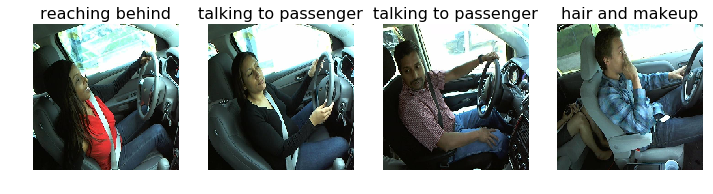

In [72]:
plots(imgs, titles=true_labels)